In [2]:
import re

import pandas as pd

### Загрузка файлов

In [8]:
docs = pd.read_csv('../datasets/docs_ibm_wiki_cleaned.csv')

In [9]:
orgs = pd.read_csv('../datasets/orgs_ibm_wiki_cleaned.csv')

In [12]:
docs_orgs = docs.join(orgs.set_index('uuid'),on='uuid',how='left')

### Генерация ORGID

In [39]:
orgs_ids = dict.fromkeys(docs_orgs['organization'].unique())

In [41]:
for i,key in enumerate(orgs_ids):
    orgs_ids[key] = f'ORG{(i+1):06d}'

### Backup ORGID

In [32]:
#import csv

#org_list = [{'id':value, 'name':key} for key,value in orgs_ids.items()]

#with open('../datasets/orgs_ids.csv','w',encoding='utf8') as id_file:
#    writer = csv.DictWriter(id_file,fieldnames=['id','name'])
#    writer.writeheader()
#    writer.writerows(org_list)

### Подготовка к замене

Создаем словать вида {uuid : [org names]}, где org_names - организации, встречающиеся в этом документе, упорядоченные по уменьшению длины имени. Таким образом для каждого документа будем быстро получать список организаций, уже упорядоченных по длине имени.

In [34]:
uuid_orgs = docs_orgs.groupby('uuid')['organization'].apply(list).T.to_dict()

In [37]:
uuid_orgs = {uuid: sorted(org, key= lambda x: -len(x)) for uuid, org in uuid_orgs.items()}

### Замена имен на ID

In [256]:
text_replaced = []


def replace_orgs(row, uuid_orgs, orgs_ids, text_replaced):
    uuid = row['uuid']
    text = row['text']
    org_names = uuid_orgs.get(uuid)
    
    count_of_subs = dict()
    
    if org_names:
        for org_name in org_names:
            org_id = orgs_ids[org_name]
            pattern = f'(?P<start>\A|\W){re.escape(org_name)}(?P<end>\W|\Z)'
            repl = f'\g<start>{re.escape(org_id)}\g<end>'
            sub_result = re.subn(pattern, repl, text,flags=re.I)
            text = sub_result[0]
            count_of_subs[org_name] = sub_result[1]
    else:
        text = None
    result = {'uuid':uuid, 'text': text, 'counts': count_of_subs}
    text_replaced.append(result)
    
docs.apply(replace_orgs, axis=1, aggs=(uuid_orgs, orgs_ids, text_replaced))
#None just to clear output
None

### Проверяем, совпало ли количество замен с количеством упоминаний.

In [257]:
#Casting to dict just for convenience and speed of access
text_replaced_dict = {doc['uuid']: {'text':doc['text'], 'counts': doc['counts']} for doc in text_replaced}

In [302]:
def set_new_counts(row,text_replaced_dict):
    uuid = row['uuid']
    org_name = row['organization']
    sub_result = text_replaced_dict.get(uuid)
    if sub_result:
        count = sub_result['counts'].get(org_name)
        if count:
            return count
    return 0  

In [243]:
orgs['new_count'] = orgs.apply(set_new_counts, axis=1, args=(text_replaced_dict,))

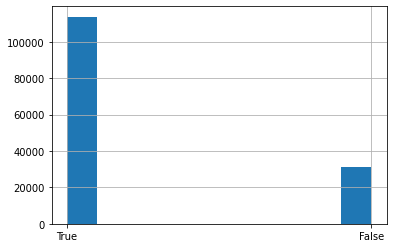

In [258]:
(orgs['new_count'] == orgs['org_count']).astype(str).hist()

### Количесво не совпадает в части случаев. 

Связано с тем, что часть записей  в другой форме, а часть упоминаний не разпознал IBM. Из-за сложности с сопоставлением названий и последующим сопоставлением сантиментов далее будем работать только с теми организациями, у которых количество совпало. Сформируем заново список организаций и проделаем для них все шаги выше.

In [275]:
orgs_to_substitute = orgs[orgs['new_count'] == orgs['org_count']].drop('new_count', axis=1)

### Т.к. количество записей с организациями изменилось, пересчитаем количество организаций на документ.

In [276]:
orgs_per_doc = orgs_to_substitute.groupby('uuid').agg({'organization': 'count'}).organization.T.to_dict()

In [277]:
orgs_to_substitute['orgs_in_doc'] = orgs_to_substitute.uuid.apply(lambda uuid: orgs_per_doc[uuid])

### Добавляем соответствующие id, чтобы не хранить их в отдельном файле и сохраним организации

In [280]:
orgs_to_substitute['org_id'] = orgs_to_substitute.organization.apply(lambda org: orgs_ids[org])

In [284]:
orgs_to_substitute.to_csv('orgs_sub_name_id.csv', index=False)

### Аналогично отфильтруем и документы

In [287]:
doc_subst_uuids = set(orgs_to_substitute.uuid.unique())

In [311]:
docs_to_substitute = docs[docs.uuid.isin(doc_subst_uuids)].copy()

In [292]:
docs_to_substitute.to_csv('docs_to_sub.csv', index=True)

### Повторим шаги по замене имен

In [295]:
uuid_orgs_2 = orgs_to_substitute.groupby('uuid')['organization'].apply(list).T.to_dict()
uuid_orgs_2 = {uuid: sorted(org, key= lambda x: -len(x)) for uuid, org in uuid_orgs_2.items()}

In [298]:
text_replaced_2 = []


def replace_orgs(row, uuid_orgs, orgs_ids, text_replaced):
    uuid = row['uuid']
    text = row['text']
    org_names = uuid_orgs.get(uuid)
    
    count_of_subs = dict()
    
    if org_names:
        for org_name in org_names:
            org_id = orgs_ids[org_name]
            pattern = f'(?P<start>\A|\W){re.escape(org_name)}(?P<end>\W|\Z)'
            repl = f'\g<start>{re.escape(org_id)}\g<end>'
            sub_result = re.subn(pattern, repl, text,flags=re.I)
            text = sub_result[0]
            count_of_subs[org_name] = sub_result[1]
    else:
        text = None
    result = {'uuid':uuid, 'text': text, 'counts': count_of_subs}
    text_replaced.append(result)
    
    
docs_to_substitute.apply(replace_orgs, axis=1, args=(uuid_orgs_2, orgs_ids, text_replaced_2))
#None just to clear output
None

In [300]:
#Casting to dict just for convenience and speed of access
text_replaced_2_dict = {doc['uuid']: {'text':doc['text'], 'counts': doc['counts']} for doc in text_replaced}

In [304]:
orgs_to_substitute['new_count'] = orgs_to_substitute.apply(set_new_counts, axis=1, args=(text_replaced_2_dict,))

In [312]:
def get_replaced_text(uuid, text_replaced_dict):
    sub_result = text_replaced_dict.get(uuid)
    if sub_result:
        text = sub_result.get('text')
        if text:
            return text
    return None

docs_to_substitute['text_w_ids'] = docs_to_substitute['uuid'].apply(get_replaced_text, args=(text_replaced_2_dict,))

In [317]:
docs_to_substitute.text_w_ids.apply(lambda x: x is None).sum()

0

In [318]:
docs_to_substitute.to_csv('docs_sub_name_id.csv', index=False)